In [8]:
import gymnasium as gym
env = gym.make("LunarLander-v3", render_mode="human")
observation, info = env.reset()
rewards = 0
steps = 0
episode_over = False
while not episode_over:
    action = env.action_space.sample()  # agent policy that uses the observation and info
    observation, reward, terminated, truncated, info = env.step(action)
    rewards+= reward
    steps += 1
    episode_over = terminated or truncated
print(f"Rewards: {rewards} Steps: {steps}")
env.close() 

Rewards: -110.64190347505833 Steps: 72


In [9]:
env = gym.make("LunarLander-v3", render_mode="human")
observation, info = env.reset()
rewards = 0
steps = 0
episode_over = False
while not episode_over:
    action = 0  # agent policy that uses the observation and info
    observation, reward, terminated, truncated, info = env.step(action)
    rewards+= reward
    steps += 1
    episode_over = terminated or truncated
print(f"Rewards: {rewards} Steps: {steps}")
env.close() 

Rewards: -113.49401977615489 Steps: 55


In [10]:
import numpy as np
N_ACTION = 4
N_STATE_DIM = 8
W = np.zeros((N_ACTION, N_STATE_DIM))
EPSILON = 0.1
def agent(observation):
    if np.random.random() < EPSILON:
        return env.action_space.sample()
    else:
        state = np.array(observation).reshape(-1)
        qvals = W @ state
        return np.argmax(qvals)


In [11]:
env = gym.make("LunarLander-v3", render_mode="human")
N_EPISODE = 20
EPSILON = 0.1
DISCOUNT = 1.0
learning_rate = 0.001
episode_rewards = np.zeros(N_EPISODE)
for ep in range(N_EPISODE):
    observation, info = env.reset()
    while True:
        state = np.array(observation).reshape(-1)
        action = agent(observation)
        new_observation, reward, terminated, truncated, info = env.step(action)

        new_state = np.array(new_observation).reshape(-1)
        new_action = agent(new_observation)
        target = reward + DISCOUNT*np.dot(W[new_action, :], new_state)

        W[action, :] += learning_rate * (target - np.dot(W[action, :], state)) * state
        episode_rewards[ep] = reward
        if terminated or truncated:
            break
        observation = new_observation


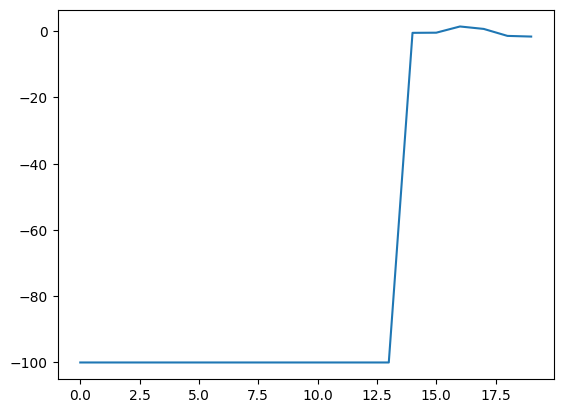

In [12]:
import matplotlib.pyplot as plt
episode_rewards
plt.plot(episode_rewards)

In [20]:
import tensorflow as tf
def simple_nn():
    x = tf.keras.Input(shape = (8, ))
    h1 = tf.keras.layers.Dense(64, activation = 'relu')(x)
    h2 = tf.keras.layers.Dense(64, activation = 'relu')(h1)
    out = tf.keras.layers.Dense(4)(h2)
    return tf.keras.Model(inputs = x, outputs = out)

In [22]:
model = simple_nn()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,996 (19.52 KB)

 Trainable params: 4,996 (19.52 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
state = env.observation_space.sample()   # we sample one observation
x = model(tf.convert_to_tensor([state]))  # run the model on it,
print(x)

tf.Tensor([[-1.0312848 -1.4232503 -1.4366331  1.5011178]], shape=(1, 4), dtype=float32)


In [24]:
observation, info = env.reset()
with tf.GradientTape() as t:
    action_probs = model(tf.convert_to_tensor([observation]))
    new_observation, reward, terminated, truncated, info = env.step(action)

    new_action_probs = model(tf.convert_to_tensor([new_observation]))
    target = reward + DISCOUNT * tf.math.reduce_max(new_action_probs)
    loss = (target - tf.math.reduce_max(action_probs))**2
    grad = t.gradient(loss, model.trainable_variables)

for var, g in zip(model.trainable_variables, grad):
    print(f'{var.name}, shape: {g.shape}')

kernel, shape: (8, 64)
bias, shape: (64,)
kernel, shape: (64, 64)
bias, shape: (64,)
kernel, shape: (64, 4)
bias, shape: (4,)


In [27]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3) # Instantiate an optimizer
# Run one step of gradient descent by updating the value of the variables to minimize the loss.
optimizer.apply_gradients(zip(grad, model.trainable_weights))

<Variable path=SGD/iteration, shape=(), dtype=int64, value=1>

In [28]:
N_EPISODE = 20
EPSILON = 0.1
DISCOUNT_FACTOR = 1.0
LR = 1e-3
optimizer = tf.keras.optimizers.SGD(learning_rate = LR)
episode_rewards = np.zeros(N_EPISODE)
for ep in range(N_EPISODE):
    observation, info = env.reset()
    while True:
        with tf.GradientTape() as t:
            action_probs = model(tf.convert_to_tensor([observation]))
            action = np.argmax(action_probs.numpy()[0])
            if np.random.random() < EPSILON:
                action = env.action_space.sample()
            new_observation, reward, terminated, truncated, info = env.step(action)

            new_action_probs = model(tf.convert_to_tensor([new_observation]))
            target = reward+DISCOUNT_FACTOR*tf.math.reduce_max(new_action_probs)

            loss = (target-action_probs.numpy()[0][action])**2
            grad = t.gradient(loss, model.trainable_variables)

            optimizer.apply_gradients(zip(grad, model.trainable_weights))
            episode_rewards[ep] += reward
            if terminated or truncated:
                break
            observation = new_observation



In [ ]:
plt.plot(episode_rewards)